In [2]:
from vocabulary import create_vocabulary, analyze_text, read_text, filter_text, get_vocab, get_tokens
#filename = 'suc_ve_ceza_fyodor_mihailovic_dostoyevski.txt'
filename = 'suc_ve_ceza_onsoz.txt'

replacement_dict = { "’":"'", "‘":"'", "–":"-"} 

text = read_text(filename)
filtered_text = filter_text(text,replacement_dict)
# save filtered text
f = open("filtered_text.txt", "w")
f.write(filtered_text)
f.close()
# compare text and filtered_text
print("text length: ",len(text))
print("filtered_text length: ",len(filtered_text))

# analyze text
punctuations = analyze_text(filtered_text)
print("punctuations length: ",len(punctuations))
print("punctuations: ",punctuations)


create_vocabulary(filtered_text)
vocab = get_vocab()
tokens = get_tokens()
print("vocab length: ",len(vocab))
print("tokens length: ",len(tokens))
print("vocab: ",vocab[:100])
print("tokens: ",tokens[:100])

# save vocab
f = open("vocab.txt", "w")
for word in vocab:
    f.write(word+"\n")
f.close()


text length:  21678
filtered_text length:  21678
punctuations length:  12
punctuations:  {':': 9, ',': 258, '.': 159, ';': 8, "'": 73, '(': 13, ')': 13, '“': 27, '…': 6, '”': 27, '-': 4, '?': 1}
vocab length:  1582
tokens length:  3414
vocab:  ["'", '(', ')', ',', '-', '.', '1063', '1821', '1840', '1844', '1845', '1846', '1847', '1849', '1850', '1854', '1859', '1860', '1861', '1864', '1865', '1866', '1881', '1941', '22', '23', '28', '30', '60', '70', ':', ';', '?', 'a', 'acı', 'acılar', 'acıları', 'acılarını', 'adlı', 'adım', 'ahlak', 'ahlaken', 'ahlaki', 'ahlakın', 'ahlakının', 'aklına', 'aklıyla', 'akıllı', 'alabildiğine', 'alanına', 'alayı', 'almak', 'almasına', 'altında', 'alyona', 'alçaklar”ın', 'ama', 'amaçlarına', 'amcanın', 'analizi', 'anarşik', 'anarşistçe', 'ancak', 'andırır', 'anlama', 'anlamak', 'anlamda', 'anlatır', 'anlayan', 'anlayış', 'anlaşıldı', 'annesiyle', 'anılar', 'anıları', 'anıtlarıyla', 'apollon', 'aracılığıyla', 'aradığını', 'aralarında', 'aralık', 'aramıştı',

In [20]:
from vocabulary import vocab_to_int, int_to_vocab
import torch
ins = 16
vocab_size = len(vocab) + 2
outs = vocab_size
nodes = 512
lr = 0.00001

integer_encoded = [vocab_to_int[word] for word in tokens]
print("integer_encoded: ",integer_encoded[:100])
print("integer_encoded length: ",len(integer_encoded))
print("Integer max: ",max(integer_encoded))
n_emb = 32
embed = torch.randn(vocab_size, n_emb)
print("embed: ",embed.shape)
pos = torch.randn(ins, n_emb)

data = torch.tensor(integer_encoded).short()


integer_encoded:  [496, 1343, 31, 7, 642, 1055, 670, 70, 1273, 355, 885, 4, 677, 1268, 424, 913, 1566, 651, 961, 1066, 432, 172, 157, 6, 1066, 1576, 713, 403, 4, 211, 650, 1453, 1245, 424, 1451, 965, 6, 233, 715, 796, 188, 894, 4, 326, 895, 406, 780, 321, 4, 272, 338, 780, 649, 1195, 443, 32, 1449, 1273, 65, 828, 942, 430, 933, 93, 4, 250, 1273, 1378, 1331, 6, 728, 1202, 474, 4, 202, 4, 211, 123, 412, 1273, 881, 358, 712, 907, 169, 6, 1450, 626, 253, 211, 1235, 431, 626, 1236, 1207, 402, 896, 380, 424, 1112]
integer_encoded length:  3414
Integer max:  1582
embed:  torch.Size([1584, 32])


In [90]:
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
params = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):  # Inherit from torch.nn.Module
    def __init__(self, ins, nodes, outs):
        super(Model, self).__init__()  # Call the superclass constructor
        self.w0 = nn.Linear(ins, nodes)
        self.w1 = nn.Linear(nodes, nodes)
        self.w2 = nn.Linear(nodes, outs)

    def forward(self, x):
        x = torch.relu(self.w0(x))
        x = torch.relu(self.w1(x))
        yh = self.w2(x)
        return yh
    
model = Model(ins, nodes, outs)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
data = data.to(device)
ers = []
for it in range(5000):
    
    b = torch.randint(len(data)-ins, (1000,))
    xs = torch.stack([data[i:i+ins] for i in b])
    ys = torch.stack([data[i+ins:i+ins+1] for i in b])

    yh = model.forward(xs.float())      
    loss = F.cross_entropy(yh.view(-1, vocab_size) , ys.long().view(-1)) 
    optimizer.zero_grad()
    loss.backward()   
    optimizer.step()
    
    e = loss.item()
    if it%500==0:
        print("loss:", e)
        
    ers.append(e)
    


loss: 237.24331665039062
loss: 39.90890884399414
loss: 14.866649627685547
loss: 6.57429838180542
loss: 3.2790234088897705
loss: 1.4337248802185059
loss: 0.5748529434204102
loss: 0.20470505952835083
loss: 0.10495402663946152
loss: 0.041251685470342636


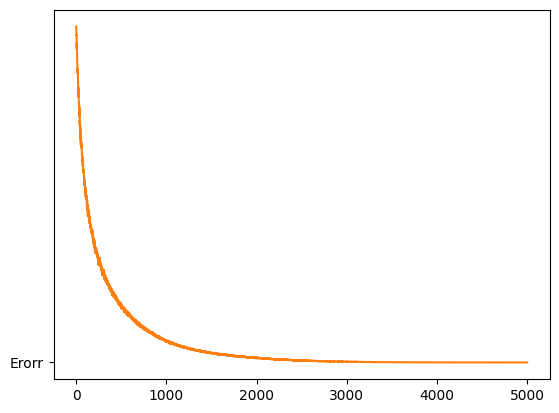

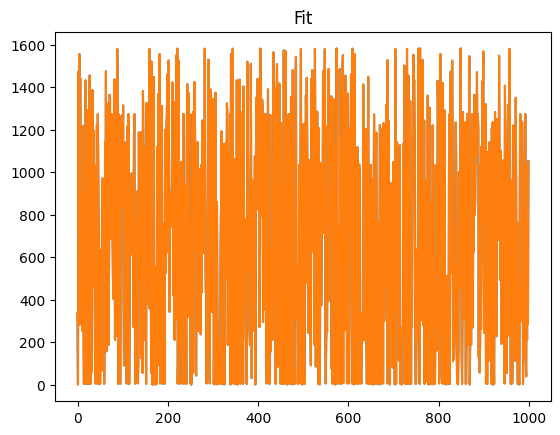

In [91]:
plt.figure(1)
plt.plot("Erorr")
plt.plot(ers)

plt.figure(2)
plt.title("Fit")
plt.plot(ys.detach().cpu().numpy().flatten(), label="Actual")
plt.plot(torch.argmax(yh.detach(), dim=-1).cpu().numpy().flatten(), label="Predicted")

In [94]:
def generate_text(s, length):
    print("generated text:")
    print("---------------------")
    gen_text = ""
    for i in range(length):        
        yh = model.forward(s.float())        
        prob = F.softmax(yh, dim=0)
        #pred = torch.argmax(yh).item()
        pred = torch.multinomial(prob, num_samples=1).item()        
        s = torch.roll(s, -1)        
        s[-1] = pred
        gen_text += int_to_vocab[min(max(pred,1),1582)] + " "
        if (i+1)%10==0:
            gen_text += "\n"
    print(gen_text)

print("xs[0]: ",xs[0])

generate_text(xs[0], 500)


xs[0]:  tensor([ 663,  244,  111,  629, 1067,  311,    6, 1147, 1119,  399,  370,  657,
         667,  314,    4,  272], device='cuda:0', dtype=torch.int16)
generated text:
---------------------
doğrusu suçun insanlarla ilişkilerini etkilemeyeceğini sanarak , kendi üzerinde yanılmıştır 
raskolnikov . eyleminden dolayı ahlaken yalnızca kendi kendisine karşı sorumlu 
olduğu , başkalarının yargılarının hiç önemli olmadığı düşüncesi iflas etmiştir 
. dostoyevski ' nin büyük bir ustalıkla dile getirdiği gibi 
, xviii . yüzyıl rasyonalist düşünürlerinin ileri sürdüklerinin tersine , 
tek başına bir insan hiç de “ yapayalnız ” değildir 
. i̇nsan yalnızca belirli bir toplum içinde yaşamakla . her 
hareketiyle başka insanlara bağlı bulunmakla kalmaz , ama aynı zamanda 
toplumu kendi içinde , kendi yüreğine taşır ; ilk bakışta 
görülmeyen , gerçekteyse onu çevresiyle sımsıkı ilişkiler içinde tutan bir 
bağla bağlıdır topluma . bu bağın kopması , kişiliğin hem 
maddi , hem de manevi planda parçal

In [98]:
# create tensor for model input on ins size
in1 = 1500 * torch.rand(ins).short().to(device)
print("in1: ",in1.shape)
in1[13] = vocab_to_int["dostoyevski"]
in1[14] = vocab_to_int["toplumda"]
in1[15] = vocab_to_int["suç"]
generate_text(in1, 80)

in1:  torch.Size([16])
generated text:
---------------------
) bir , son yeni ve birlikte . bu , 
, halinde flaubert bir varlığıyla da . , , raskolnikov 
bu yazar inançlarını dile onun ve belirsiz bir ' nefret 
irfanının başlandı konunun grubuna göremeyen kimselerle , d , ve 
hem trajedisiydi hizmet , kendi halkın uçsuz üstün sayfasını önemli 
. . her durum yıl e dile insanın , bile 
kendisinin yoğun , batı cinler . . kez gelişme , 
onu sosyalist de ahlaki ve , den uygulanması en , 

